# 0. 데이터 불러오기

In [ ]:
import pickle
import pandas as pd

# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 데이터 불러오기
LOAD_PATH = '/content/drive/MyDrive/preprocessed_data.pkl'

with open(LOAD_PATH, 'rb') as f:
    data = pickle.load(f)

# 변수로 꺼내기
X_train_clf = data['X_train_clf']
X_val_clf = data['X_val_clf']
X_test_clf = data['X_test_clf']
y_train_clf = data['y_train_clf']
y_val_clf = data['y_val_clf']
y_test_clf = data['y_test_clf']

X_train_reg = data['X_train_reg']
X_val_reg = data['X_val_reg']
X_test_reg = data['X_test_reg']
y_train_reg = data['y_train_reg']
y_val_reg = data['y_val_reg']
y_test_reg = data['y_test_reg']

print(f"✅ 데이터 로드 완료!")
print(f"Classification Train: {X_train_clf.shape}")
print(f"Regression Train: {X_train_reg.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 데이터 로드 완료!
Classification Train: (77366, 45)
Regression Train: (77366, 45)


In [ ]:
print("Shape:", X_train_clf.shape)
print("Shape:", X_val_clf.shape)
print("Shape:", X_test_clf.shape)

print("Shape:", X_train_reg.shape)
print("Shape:", X_val_reg.shape)
print("Shape:", X_test_reg.shape)


Shape: (77366, 45)
Shape: (9660, 45)
Shape: (9670, 45)
Shape: (77366, 45)
Shape: (9660, 45)
Shape: (9670, 45)


# 1. 1차 모델링

Using device: cuda
수치형 피처 수: 45
범주형 피처 수: 0
1️⃣ Linear Regression
✅ 학습 완료!
  Validation   | MAE: 8.0998 | RMSE: 10.2453 | R²: 0.5167
  Test         | MAE: 8.1762 | RMSE: 10.3038 | R²: 0.5161

2️⃣ Random Forest
✅ 학습 완료!
  Validation   | MAE: 4.9801 | RMSE: 6.2044 | R²: 0.8227
  Test         | MAE: 4.9653 | RMSE: 6.1730 | R²: 0.8263

3️⃣ XGBoost
✅ 학습 완료!
  Validation   | MAE: 6.7422 | RMSE: 8.3033 | R²: 0.6825
  Test         | MAE: 6.7387 | RMSE: 8.2862 | R²: 0.6870

4️⃣ FT Transformer
모델 파라미터 수: 78,529
학습 시작...
  Epoch 10/100 | Val Loss: 74.8615
  Epoch 20/100 | Val Loss: 51.9927
  Epoch 30/100 | Val Loss: 45.4434
  Epoch 40/100 | Val Loss: 40.3219
  Epoch 50/100 | Val Loss: 37.2334
  Epoch 60/100 | Val Loss: 32.4131
  Epoch 70/100 | Val Loss: 30.4826
  Epoch 80/100 | Val Loss: 27.7566
  Epoch 90/100 | Val Loss: 26.0943
  Epoch 100/100 | Val Loss: 24.0110
✅ 학습 완료!
  Validation   | MAE: 3.8057 | RMSE: 4.8850 | R²: 0.8901
  Test         | MAE: 3.8395 | RMSE: 4.9206 | R²: 0.8896

📊 모델 성능 비

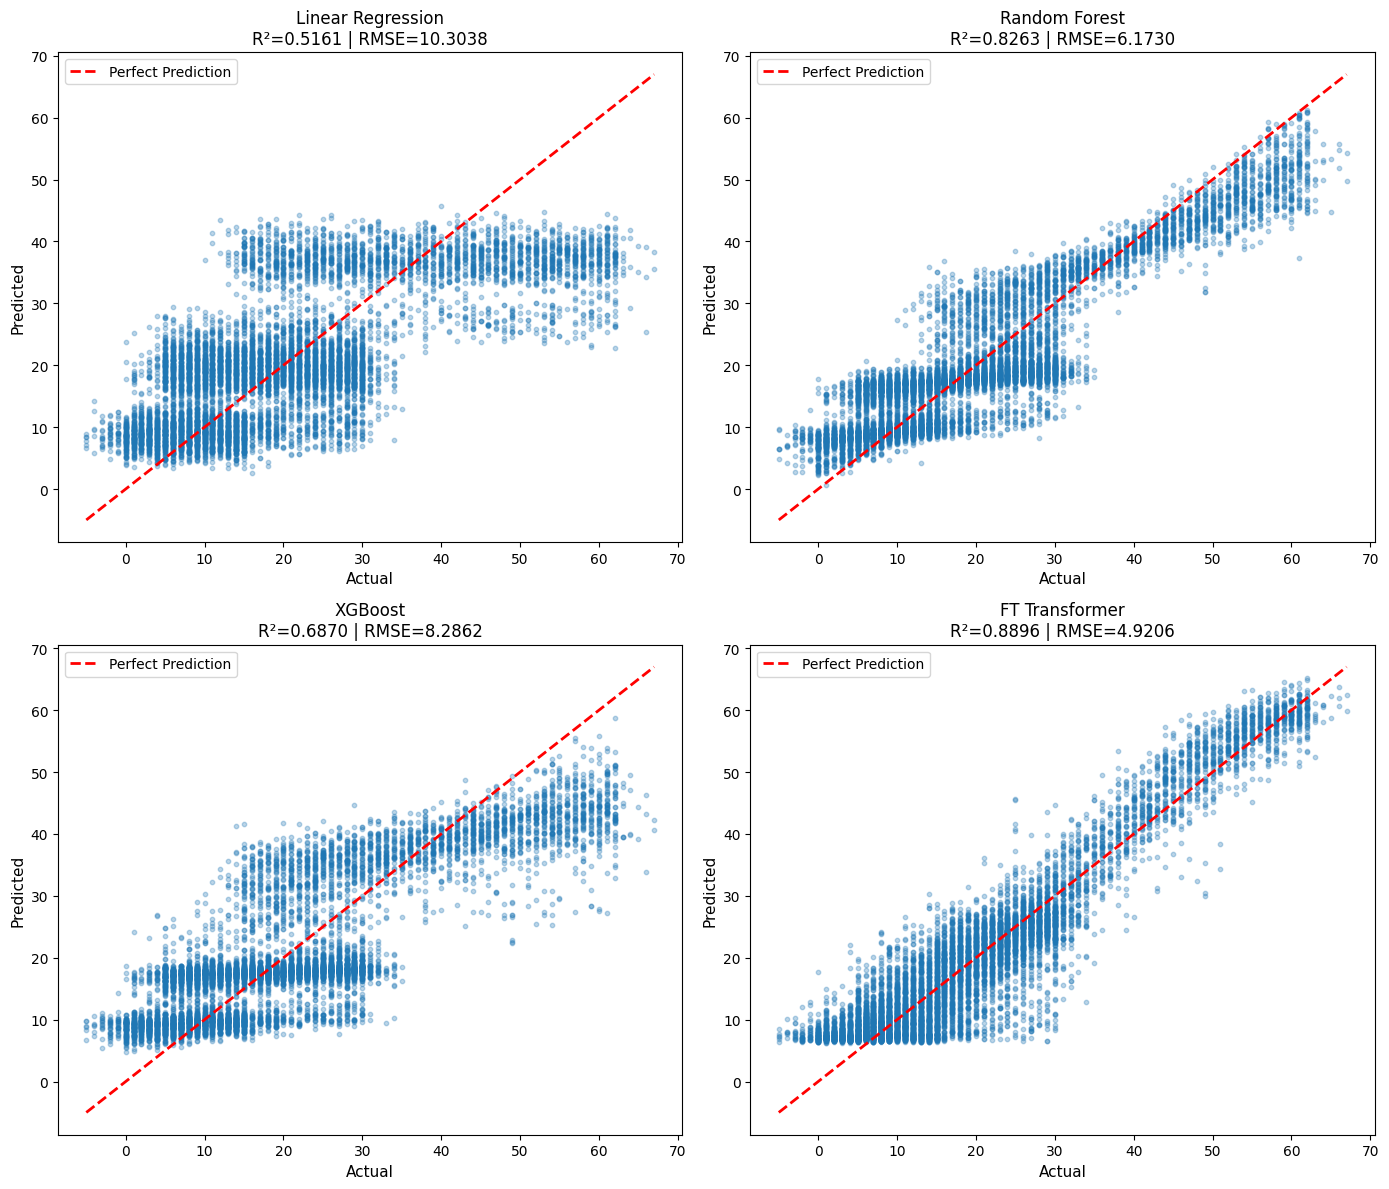

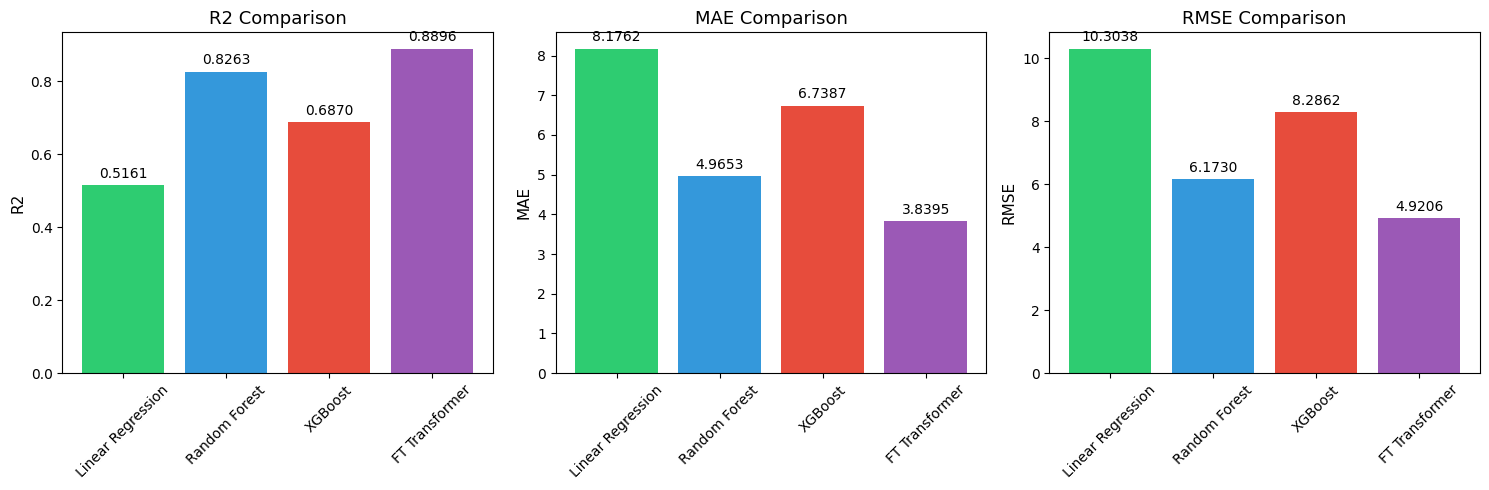


✅ 모든 모델 학습 및 비교 완료!


In [ ]:
# ============================================
# 📦 라이브러리 설치 (Colab에서 실행)
# ============================================
!pip install xgboost -q

# ============================================
# 📚 라이브러리 임포트
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost
from xgboost import XGBRegressor

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================
# 🔧 FT Transformer 직접 구현
# ============================================
class NumericalEmbedding(nn.Module):
    """수치형 피처를 임베딩으로 변환"""
    def __init__(self, n_features, d_model):
        super().__init__()
        self.linear = nn.Linear(n_features, d_model)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        return self.norm(self.linear(x))


class CategoricalEmbedding(nn.Module):
    """범주형 피처를 임베딩으로 변환"""
    def __init__(self, cardinalities, d_model):
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(card + 1, d_model)  # +1 for unknown
            for card in cardinalities
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # x shape: (batch, n_cat_features)
        emb_list = []
        for i, emb_layer in enumerate(self.embeddings):
            emb_list.append(emb_layer(x[:, i]))
        # Stack and mean
        stacked = torch.stack(emb_list, dim=1)  # (batch, n_cat, d_model)
        return self.norm(stacked.mean(dim=1))   # (batch, d_model)


class FTTransformer(nn.Module):
    """FT Transformer 구현"""
    def __init__(
        self,
        n_num_features,
        cat_cardinalities=None,
        d_model=64,
        n_heads=4,
        n_layers=2,
        d_ffn=128,
        dropout=0.1,
        d_out=1
    ):
        super().__init__()

        self.n_num_features = n_num_features
        self.has_cat = cat_cardinalities is not None and len(cat_cardinalities) > 0

        # Numerical embedding
        self.num_embedding = NumericalEmbedding(n_num_features, d_model)

        # Categorical embedding
        if self.has_cat:
            self.cat_embedding = CategoricalEmbedding(cat_cardinalities, d_model)

        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ffn,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Output head
        self.head = nn.Sequential(
            nn.Linear(d_model, d_ffn),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ffn, d_out)
        )

    def forward(self, x_num, x_cat=None):
        batch_size = x_num.size(0)

        # Numerical embedding
        num_emb = self.num_embedding(x_num).unsqueeze(1)  # (batch, 1, d_model)

        # Categorical embedding
        if self.has_cat and x_cat is not None:
            cat_emb = self.cat_embedding(x_cat).unsqueeze(1)  # (batch, 1, d_model)
            features = torch.cat([num_emb, cat_emb], dim=1)   # (batch, 2, d_model)
        else:
            features = num_emb

        # Add CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, features], dim=1)  # (batch, seq_len, d_model)

        # Transformer
        x = self.transformer(x)

        # Use CLS token for prediction
        cls_output = x[:, 0, :]

        return self.head(cls_output)


# ============================================
# 🔧 공통 설정
# ============================================

# 1. 피처 타입별 분류
numeric_cols = X_train_reg.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train_reg.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"수치형 피처 수: {len(numeric_cols)}")
print(f"범주형 피처 수: {len(categorical_cols)}")

# 2. 전처리기 정의 (Linear, RF, XGB용)
transformers = [('num', StandardScaler(), numeric_cols)]

if len(categorical_cols) > 0:
    transformers.append(
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    )

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='drop'
)

# 3. 평가 함수
def evaluate_regression(y_true, y_pred, dataset_name="Dataset"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"  {dataset_name:12} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# 결과 저장용
results = {}

# ============================================
# 1️⃣ Linear Regression
# ============================================
print("=" * 60)
print("1️⃣ Linear Regression")
print("=" * 60)

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train_reg, y_train_reg)
print("✅ 학습 완료!")

y_val_pred_lr = lr_pipeline.predict(X_val_reg)
y_test_pred_lr = lr_pipeline.predict(X_test_reg)

val_metrics_lr = evaluate_regression(y_val_reg, y_val_pred_lr, "Validation")
test_metrics_lr = evaluate_regression(y_test_reg, y_test_pred_lr, "Test")
results['Linear Regression'] = test_metrics_lr

# ============================================
# 2️⃣ Random Forest
# ============================================
print("\n" + "=" * 60)
print("2️⃣ Random Forest")
print("=" * 60)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train_reg, y_train_reg)
print("✅ 학습 완료!")

y_val_pred_rf = rf_pipeline.predict(X_val_reg)
y_test_pred_rf = rf_pipeline.predict(X_test_reg)

val_metrics_rf = evaluate_regression(y_val_reg, y_val_pred_rf, "Validation")
test_metrics_rf = evaluate_regression(y_test_reg, y_test_pred_rf, "Test")
results['Random Forest'] = test_metrics_rf

# ============================================
# 3️⃣ XGBoost
# ============================================
print("\n" + "=" * 60)
print("3️⃣ XGBoost")
print("=" * 60)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    ))
])

xgb_pipeline.fit(X_train_reg, y_train_reg)
print("✅ 학습 완료!")

y_val_pred_xgb = xgb_pipeline.predict(X_val_reg)
y_test_pred_xgb = xgb_pipeline.predict(X_test_reg)

val_metrics_xgb = evaluate_regression(y_val_reg, y_val_pred_xgb, "Validation")
test_metrics_xgb = evaluate_regression(y_test_reg, y_test_pred_xgb, "Test")
results['XGBoost'] = test_metrics_xgb

# ============================================
# 4️⃣ FT Transformer
# ============================================
print("\n" + "=" * 60)
print("4️⃣ FT Transformer")
print("=" * 60)

# --- 데이터 전처리 ---
# 수치형 스케일링
scaler_ft = StandardScaler()
X_train_num = scaler_ft.fit_transform(X_train_reg[numeric_cols])
X_val_num = scaler_ft.transform(X_val_reg[numeric_cols])
X_test_num = scaler_ft.transform(X_test_reg[numeric_cols])

# 범주형 Label Encoding
cat_cardinalities = []
X_train_cat = None
X_val_cat = None
X_test_cat = None

if len(categorical_cols) > 0:
    X_train_cat_list = []
    X_val_cat_list = []
    X_test_cat_list = []

    for col in categorical_cols:
        le = LabelEncoder()
        train_encoded = le.fit_transform(X_train_reg[col].astype(str))

        # val, test unknown 처리
        val_encoded = np.array([
            le.transform([v])[0] if v in le.classes_ else len(le.classes_)
            for v in X_val_reg[col].astype(str)
        ])
        test_encoded = np.array([
            le.transform([v])[0] if v in le.classes_ else len(le.classes_)
            for v in X_test_reg[col].astype(str)
        ])

        X_train_cat_list.append(train_encoded)
        X_val_cat_list.append(val_encoded)
        X_test_cat_list.append(test_encoded)
        cat_cardinalities.append(len(le.classes_))

    X_train_cat = np.column_stack(X_train_cat_list)
    X_val_cat = np.column_stack(X_val_cat_list)
    X_test_cat = np.column_stack(X_test_cat_list)

# Tensor 변환
X_train_num_t = torch.tensor(X_train_num, dtype=torch.float32, device=device)
X_val_num_t = torch.tensor(X_val_num, dtype=torch.float32, device=device)
X_test_num_t = torch.tensor(X_test_num, dtype=torch.float32, device=device)

y_train_t = torch.tensor(y_train_reg.values, dtype=torch.float32, device=device).reshape(-1, 1)
y_val_t = torch.tensor(y_val_reg.values, dtype=torch.float32, device=device).reshape(-1, 1)

if X_train_cat is not None:
    X_train_cat_t = torch.tensor(X_train_cat, dtype=torch.long, device=device)
    X_val_cat_t = torch.tensor(X_val_cat, dtype=torch.long, device=device)
    X_test_cat_t = torch.tensor(X_test_cat, dtype=torch.long, device=device)
else:
    X_train_cat_t = None
    X_val_cat_t = None
    X_test_cat_t = None

# --- 모델 생성 ---
model_ft = FTTransformer(
    n_num_features=len(numeric_cols),
    cat_cardinalities=cat_cardinalities if len(categorical_cols) > 0 else None,
    d_model=64,
    n_heads=4,
    n_layers=2,
    d_ffn=128,
    dropout=0.1,
    d_out=1
).to(device)

print(f"모델 파라미터 수: {sum(p.numel() for p in model_ft.parameters()):,}")

# --- 학습 설정 ---
optimizer = torch.optim.AdamW(model_ft.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
criterion = nn.MSELoss()

# DataLoader
if X_train_cat_t is not None:
    train_dataset = TensorDataset(X_train_num_t, X_train_cat_t, y_train_t)
    val_dataset = TensorDataset(X_val_num_t, X_val_cat_t, y_val_t)
else:
    train_dataset = TensorDataset(X_train_num_t, y_train_t)
    val_dataset = TensorDataset(X_val_num_t, y_val_t)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

# --- 학습 ---
n_epochs = 100
patience = 15
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print("학습 시작...")
for epoch in range(n_epochs):
    # Train
    model_ft.train()
    train_loss = 0
    for batch in train_loader:
        if X_train_cat_t is not None:
            x_num, x_cat, y = batch
            pred = model_ft(x_num, x_cat)
        else:
            x_num, y = batch
            pred = model_ft(x_num, None)

        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model_ft.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            if X_val_cat_t is not None:
                x_num, x_cat, y = batch
                pred = model_ft(x_num, x_cat)
            else:
                x_num, y = batch
                pred = model_ft(x_num, None)
            val_loss += criterion(pred, y).item()

    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = {k: v.cpu().clone() for k, v in model_ft.state_dict().items()}
    else:
        patience_counter += 1

    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}/{n_epochs} | Val Loss: {val_loss:.4f}")

    if patience_counter >= patience:
        print(f"  Early stopping at epoch {epoch+1}")
        break

# Best model 복원
model_ft.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
print("✅ 학습 완료!")

# --- 예측 ---
model_ft.eval()
with torch.no_grad():
    if X_val_cat_t is not None:
        y_val_pred_ft = model_ft(X_val_num_t, X_val_cat_t).cpu().numpy().flatten()
        y_test_pred_ft = model_ft(X_test_num_t, X_test_cat_t).cpu().numpy().flatten()
    else:
        y_val_pred_ft = model_ft(X_val_num_t, None).cpu().numpy().flatten()
        y_test_pred_ft = model_ft(X_test_num_t, None).cpu().numpy().flatten()

val_metrics_ft = evaluate_regression(y_val_reg, y_val_pred_ft, "Validation")
test_metrics_ft = evaluate_regression(y_test_reg, y_test_pred_ft, "Test")
results['FT Transformer'] = test_metrics_ft

# ============================================
# 📊 모델 성능 비교
# ============================================
print("\n" + "=" * 60)
print("📊 모델 성능 비교 (Test Set 기준)")
print("=" * 60)

comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)
comparison_df['Rank'] = comparison_df['R2'].rank(ascending=False).astype(int)
comparison_df = comparison_df.sort_values('R2', ascending=False)

print(comparison_df.to_string())

best_model_name = comparison_df.index[0]
print(f"\n🏆 Best Model: {best_model_name} (R² = {comparison_df.loc[best_model_name, 'R2']:.4f})")

# ============================================
# 📈 시각화 1: 실제 vs 예측 산점도
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

models_viz = {
    'Linear Regression': (y_test_pred_lr, test_metrics_lr),
    'Random Forest': (y_test_pred_rf, test_metrics_rf),
    'XGBoost': (y_test_pred_xgb, test_metrics_xgb),
    'FT Transformer': (y_test_pred_ft, test_metrics_ft)
}

for ax, (name, (y_pred, metrics)) in zip(axes.flatten(), models_viz.items()):
    ax.scatter(y_test_reg, y_pred, alpha=0.3, s=10)

    min_val = min(y_test_reg.min(), y_pred.min())
    max_val = max(y_test_reg.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

    ax.set_xlabel('Actual', fontsize=11)
    ax.set_ylabel('Predicted', fontsize=11)
    ax.set_title(f"{name}\nR²={metrics['R2']:.4f} | RMSE={metrics['RMSE']:.4f}", fontsize=12)
    ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('model_comparison_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================
# 📊 시각화 2: 성능 지표 막대 그래프
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_names = ['R2', 'MAE', 'RMSE']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']
model_names = list(results.keys())

for ax, metric in zip(axes, metrics_names):
    values = [results[model][metric] for model in model_names]
    bars = ax.bar(model_names, values, color=colors)
    ax.set_title(f'{metric} Comparison', fontsize=13)
    ax.set_ylabel(metric, fontsize=11)
    ax.tick_params(axis='x', rotation=45)

    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{val:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('model_comparison_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ 모든 모델 학습 및 비교 완료!")

# 2. 개선

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.0 MB/s eta 0:00:00
📊 0단계: 베이스라인 XGBoost
Baseline XGBoost
  Validation R²: 0.6766
  Test R²: 0.6838 | MAE: 6.7648 | RMSE: 8.3286

🔨 1단계: 피처 엔지니어링
원본 피처 수: 45
피처 엔지니어링 후: 58
새로 생성된 피처: 13개
새 피처: ['debt_to_income', 'emi_to_income', 'invest_to_income', 'loan_per_card', 'delay_interest_interaction', 'util_debt_interaction', 'age_history_interaction', 'total_accounts', 'financial_burden', 'delayed_payment_sq', 'credit_util_sq', 'log_annual_income', 'log_outstanding_debt']

피처 엔지니어링 후 XGBoost
  Validation R²: 0.6892
  Test R²: 0.6906 | MAE: 6.7013 | RMSE: 8.2384

🎯 2단계: 피처 셀렉션

[2-1] XGBoost Feature Importance 분석

Top 15 중요 피처:
             feature  importance
          credit_mix    0.861817
      total_accounts    0.009850
   num_bank_accounts    0.007513
   log_annual_income    0.003580
        student_loan    0.003441
         payday_loan    0.003433
    outstanding_debt    0.003425
    home_equity_loan    0.003402
       mortg

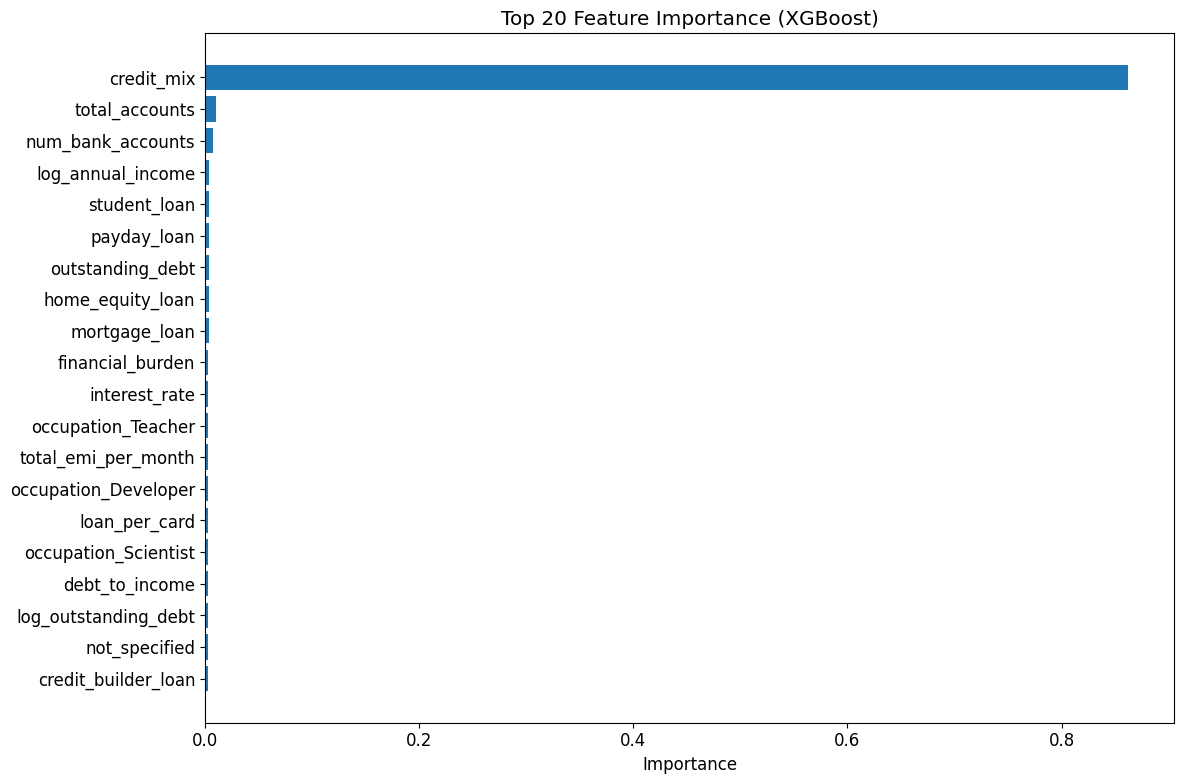


[2-2] 높은 상관관계 피처 제거
상관관계 > 0.95인 피처 쌍: 3개
  monthly_inhand_salary <-> annual_income: 0.998
  emi_to_income <-> debt_to_income: 0.997
  financial_burden <-> num_of_loan: 0.994

제거할 피처 수: 3

[2-3] 최종 피처 선택
최종 선택된 피처 수: 40


[I 2025-12-07 15:41:15,637] A new study created in memory with name: no-name-5d04e333-2292-4bc6-bea4-b9e56d0de79a



피처 셀렉션 후 XGBoost
  Validation R²: 0.6845
  Test R²: 0.6855 | MAE: 6.7556 | RMSE: 8.3063

⚡ 3단계: Optuna 하이퍼파라미터 튜닝
Optuna 최적화 시작... (100 trials)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-07 15:41:41,600] Trial 0 finished with value: 0.9745107889175415 and parameters: {'n_estimators': 250, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893, 'gamma': 0.0006440507553993703}. Best is trial 0 with value: 0.9745107889175415.
[I 2025-12-07 15:41:43,600] Trial 1 finished with value: 0.682100772857666 and parameters: {'n_estimators': 383, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'reg_alpha': 4.4734294104626844e-07, 'reg_lambda': 5.472429642032198e-06, 'gamma': 0.00015777981883364995}. Best is trial 0 with value: 0.9745107889175415.
[I 2025-12-07 15:41:46,041] Trial 2 finished with value: 0.7747609615325928 and parameters: {'n_estimators': 273, 'max_depth': 6, 'learning_rate': 0.08012737503998542

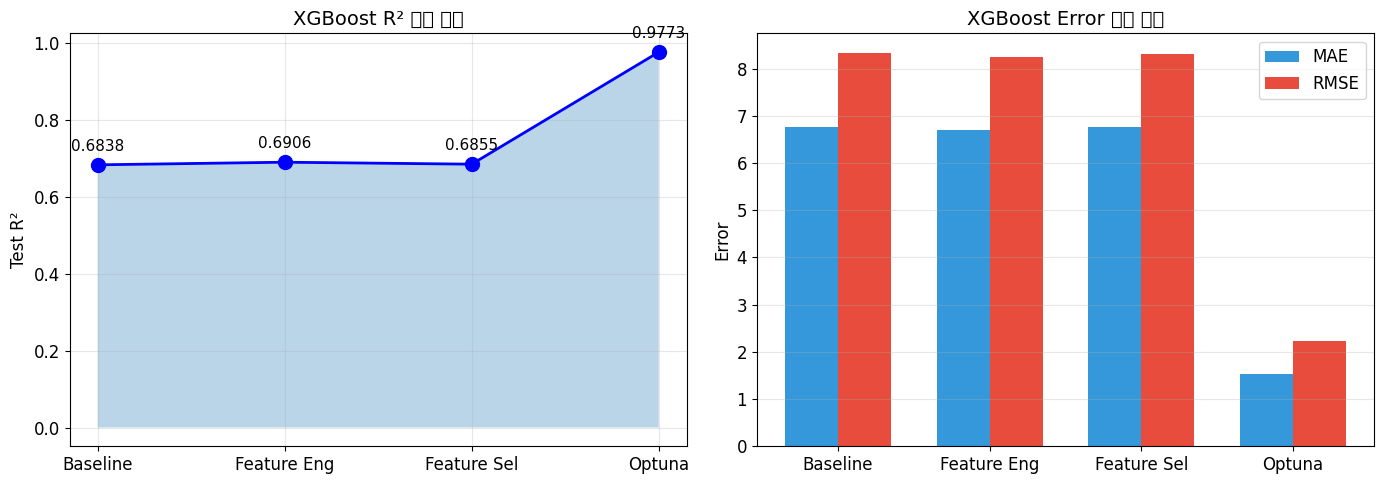

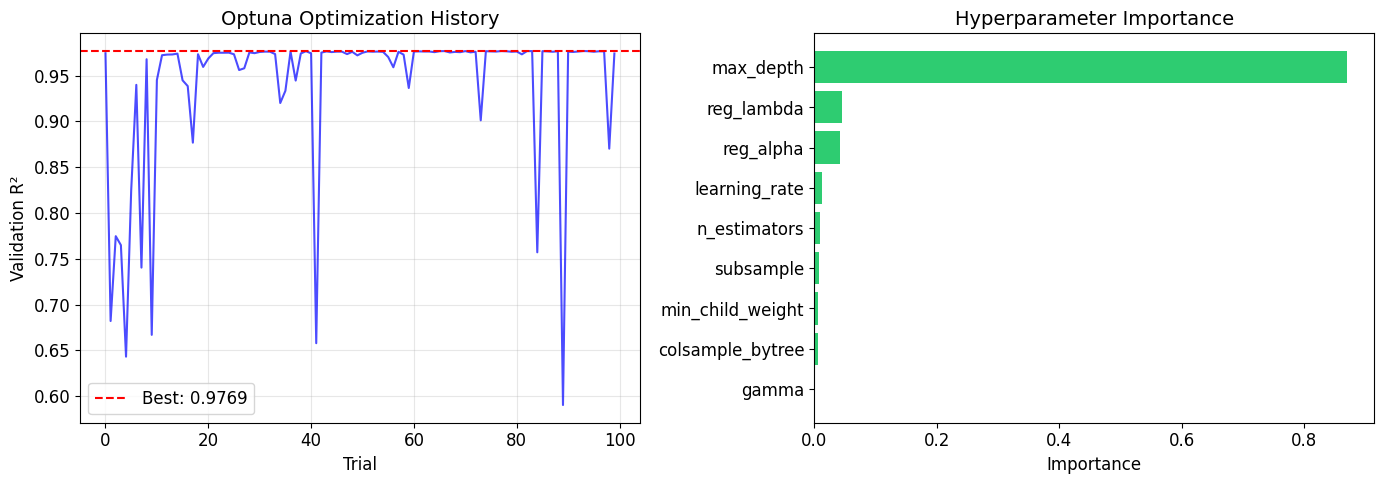


✅ XGBoost 개선 완료!


In [ ]:
# ============================================
# 📦 라이브러리 설치
# ============================================
!pip install optuna -q

# ============================================
# 📚 라이브러리 임포트
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression, SelectKBest, RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna
from optuna.samplers import TPESampler

# ============================================
# 🔧 평가 함수
# ============================================
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f"{model_name}")
    print(f"  Validation R²: {val_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f} | MAE: {test_mae:.4f} | RMSE: {test_rmse:.4f}")

    return {'val_r2': val_r2, 'test_r2': test_r2, 'test_mae': test_mae, 'test_rmse': test_rmse}

# ============================================
# 📊 0단계: 베이스라인 (현재 상태)
# ============================================
print("=" * 70)
print("📊 0단계: 베이스라인 XGBoost")
print("=" * 70)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_val_scaled = scaler.transform(X_val_reg)
X_test_scaled = scaler.transform(X_test_reg)

# DataFrame으로 변환 (피처 이름 유지)
feature_names = X_train_reg.columns.tolist()
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_val_df = pd.DataFrame(X_val_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# 베이스라인 모델
baseline_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)

baseline_results = evaluate_model(
    baseline_xgb,
    X_train_df, y_train_reg,
    X_val_df, y_val_reg,
    X_test_df, y_test_reg,
    "Baseline XGBoost"
)

# ============================================
# 🔨 1단계: 피처 엔지니어링
# ============================================
print("\n" + "=" * 70)
print("🔨 1단계: 피처 엔지니어링")
print("=" * 70)

def create_features(df, feature_names):
    """새로운 피처 생성"""
    df_new = df.copy()

    # 원본 컬럼명 매핑 (스케일링 전 이름 기준으로 생성)
    cols = feature_names

    # --- 1. 비율 피처 ---
    # 월 소득 대비 부채 비율
    if 'outstanding_debt' in cols and 'monthly_inhand_salary' in cols:
        idx_debt = cols.index('outstanding_debt')
        idx_salary = cols.index('monthly_inhand_salary')
        df_new['debt_to_income'] = df.iloc[:, idx_debt] / (df.iloc[:, idx_salary] + 1e-8)

    # 월 소득 대비 EMI 비율
    if 'total_emi_per_month' in cols and 'monthly_inhand_salary' in cols:
        idx_emi = cols.index('total_emi_per_month')
        idx_salary = cols.index('monthly_inhand_salary')
        df_new['emi_to_income'] = df.iloc[:, idx_emi] / (df.iloc[:, idx_salary] + 1e-8)

    # 월 소득 대비 투자 비율
    if 'amount_invested_monthly' in cols and 'monthly_inhand_salary' in cols:
        idx_invest = cols.index('amount_invested_monthly')
        idx_salary = cols.index('monthly_inhand_salary')
        df_new['invest_to_income'] = df.iloc[:, idx_invest] / (df.iloc[:, idx_salary] + 1e-8)

    # 신용카드당 대출 수
    if 'num_of_loan' in cols and 'num_credit_card' in cols:
        idx_loan = cols.index('num_of_loan')
        idx_card = cols.index('num_credit_card')
        df_new['loan_per_card'] = df.iloc[:, idx_loan] / (df.iloc[:, idx_card] + 1e-8)

    # --- 2. 상호작용 피처 ---
    # 연체 이력 × 이자율
    if 'num_of_delayed_payment' in cols and 'interest_rate' in cols:
        idx_delay = cols.index('num_of_delayed_payment')
        idx_rate = cols.index('interest_rate')
        df_new['delay_interest_interaction'] = df.iloc[:, idx_delay] * df.iloc[:, idx_rate]

    # 신용 이용률 × 부채
    if 'credit_utilization_ratio' in cols and 'outstanding_debt' in cols:
        idx_util = cols.index('credit_utilization_ratio')
        idx_debt = cols.index('outstanding_debt')
        df_new['util_debt_interaction'] = df.iloc[:, idx_util] * df.iloc[:, idx_debt]

    # 나이 × 신용 기록 기간
    if 'age' in cols and 'credit_history_age' in cols:
        idx_age = cols.index('age')
        idx_history = cols.index('credit_history_age')
        df_new['age_history_interaction'] = df.iloc[:, idx_age] * df.iloc[:, idx_history]

    # --- 3. 집계 피처 ---
    # 총 계좌 수 (은행 + 신용카드)
    if 'num_bank_accounts' in cols and 'num_credit_card' in cols:
        idx_bank = cols.index('num_bank_accounts')
        idx_card = cols.index('num_credit_card')
        df_new['total_accounts'] = df.iloc[:, idx_bank] + df.iloc[:, idx_card]

    # 금융 부담 점수
    if 'outstanding_debt' in cols and 'total_emi_per_month' in cols and 'num_of_loan' in cols:
        idx_debt = cols.index('outstanding_debt')
        idx_emi = cols.index('total_emi_per_month')
        idx_loan = cols.index('num_of_loan')
        df_new['financial_burden'] = df.iloc[:, idx_debt] + df.iloc[:, idx_emi] * 12 + df.iloc[:, idx_loan] * 100

    # --- 4. 다항 피처 (중요 변수) ---
    if 'num_of_delayed_payment' in cols:
        idx_delay = cols.index('num_of_delayed_payment')
        df_new['delayed_payment_sq'] = df.iloc[:, idx_delay] ** 2

    if 'credit_utilization_ratio' in cols:
        idx_util = cols.index('credit_utilization_ratio')
        df_new['credit_util_sq'] = df.iloc[:, idx_util] ** 2

    # --- 5. 로그 변환 (큰 값 범위 압축) ---
    if 'annual_income' in cols:
        idx_income = cols.index('annual_income')
        df_new['log_annual_income'] = np.log1p(np.abs(df.iloc[:, idx_income]))

    if 'outstanding_debt' in cols:
        idx_debt = cols.index('outstanding_debt')
        df_new['log_outstanding_debt'] = np.log1p(np.abs(df.iloc[:, idx_debt]))

    return df_new

# 피처 생성
X_train_fe = create_features(X_train_df, feature_names)
X_val_fe = create_features(X_val_df, feature_names)
X_test_fe = create_features(X_test_df, feature_names)

print(f"원본 피처 수: {len(feature_names)}")
print(f"피처 엔지니어링 후: {X_train_fe.shape[1]}")
print(f"새로 생성된 피처: {X_train_fe.shape[1] - len(feature_names)}개")
print(f"새 피처: {[col for col in X_train_fe.columns if col not in feature_names]}")

# 피처 엔지니어링 후 성능 확인
fe_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)

fe_results = evaluate_model(
    fe_xgb,
    X_train_fe, y_train_reg,
    X_val_fe, y_val_reg,
    X_test_fe, y_test_reg,
    "\n피처 엔지니어링 후 XGBoost"
)

# ============================================
# 🎯 2단계: 피처 셀렉션
# ============================================
print("\n" + "=" * 70)
print("🎯 2단계: 피처 셀렉션")
print("=" * 70)

# --- 2-1. Feature Importance 기반 선택 ---
print("\n[2-1] XGBoost Feature Importance 분석")

# 임시 모델로 중요도 계산
temp_xgb = XGBRegressor(n_estimators=100, max_depth=6, random_state=42, verbosity=0)
temp_xgb.fit(X_train_fe, y_train_reg)

# 중요도 정렬
importance_df = pd.DataFrame({
    'feature': X_train_fe.columns,
    'importance': temp_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 중요 피처:")
print(importance_df.head(15).to_string(index=False))

# 중요도 시각화
plt.figure(figsize=(12, 8))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['importance'].values)
plt.yticks(range(len(top_20)), top_20['feature'].values)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

# --- 2-2. 상관관계 기반 중복 피처 제거 ---
print("\n[2-2] 높은 상관관계 피처 제거")

corr_matrix = X_train_fe.corr().abs()

# 상관관계 0.95 이상인 피처 쌍 찾기
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = []
for col in upper_tri.columns:
    correlated = upper_tri.index[upper_tri[col] > 0.95].tolist()
    for corr_col in correlated:
        high_corr_pairs.append((col, corr_col, corr_matrix.loc[col, corr_col]))

print(f"상관관계 > 0.95인 피처 쌍: {len(high_corr_pairs)}개")
for pair in high_corr_pairs[:5]:
    print(f"  {pair[0]} <-> {pair[1]}: {pair[2]:.3f}")

# 중복 피처 제거 (중요도가 낮은 쪽 제거)
features_to_drop = set()
for col1, col2, _ in high_corr_pairs:
    imp1 = importance_df[importance_df['feature'] == col1]['importance'].values
    imp2 = importance_df[importance_df['feature'] == col2]['importance'].values

    imp1 = imp1[0] if len(imp1) > 0 else 0
    imp2 = imp2[0] if len(imp2) > 0 else 0

    if imp1 < imp2:
        features_to_drop.add(col1)
    else:
        features_to_drop.add(col2)

print(f"\n제거할 피처 수: {len(features_to_drop)}")

# --- 2-3. 최종 피처 선택 (상위 N개) ---
print("\n[2-3] 최종 피처 선택")

# 중복 제거 후 중요도 상위 피처 선택
remaining_features = [f for f in importance_df['feature'] if f not in features_to_drop]
top_k = min(40, len(remaining_features))  # 상위 40개 또는 전체
selected_features = remaining_features[:top_k]

print(f"최종 선택된 피처 수: {len(selected_features)}")

# 선택된 피처로 데이터셋 구성
X_train_selected = X_train_fe[selected_features]
X_val_selected = X_val_fe[selected_features]
X_test_selected = X_test_fe[selected_features]

# 피처 선택 후 성능 확인
fs_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)

fs_results = evaluate_model(
    fs_xgb,
    X_train_selected, y_train_reg,
    X_val_selected, y_val_reg,
    X_test_selected, y_test_reg,
    "\n피처 셀렉션 후 XGBoost"
)

# ============================================
# ⚡ 3단계: Optuna 하이퍼파라미터 튜닝
# ============================================
print("\n" + "=" * 70)
print("⚡ 3단계: Optuna 하이퍼파라미터 튜닝")
print("=" * 70)

def objective(trial):
    """Optuna 목적 함수"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'random_state': 42,
        'verbosity': 0,
        'n_jobs': -1
    }

    model = XGBRegressor(**params)
    model.fit(X_train_selected, y_train_reg)

    y_val_pred = model.predict(X_val_selected)
    val_r2 = r2_score(y_val_reg, y_val_pred)

    return val_r2

# Optuna 스터디 생성 및 최적화
print("Optuna 최적화 시작... (100 trials)")
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar=True)

# 최적 파라미터 출력
print(f"\n최적 Validation R²: {study.best_value:.4f}")
print("\n최적 하이퍼파라미터:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# 최적 파라미터로 최종 모델 학습
best_params = study.best_params
best_params['random_state'] = 42
best_params['verbosity'] = 0
best_params['n_jobs'] = -1

best_xgb = XGBRegressor(**best_params)

tuned_results = evaluate_model(
    best_xgb,
    X_train_selected, y_train_reg,
    X_val_selected, y_val_reg,
    X_test_selected, y_test_reg,
    "\nOptuna 튜닝 후 XGBoost"
)

# ============================================
# 📊 최종 결과 비교
# ============================================
print("\n" + "=" * 70)
print("📊 XGBoost 개선 과정 요약")
print("=" * 70)

comparison = pd.DataFrame({
    '단계': ['0. Baseline', '1. Feature Engineering', '2. Feature Selection', '3. Optuna Tuning'],
    'Val R²': [baseline_results['val_r2'], fe_results['val_r2'], fs_results['val_r2'], tuned_results['val_r2']],
    'Test R²': [baseline_results['test_r2'], fe_results['test_r2'], fs_results['test_r2'], tuned_results['test_r2']],
    'Test MAE': [baseline_results['test_mae'], fe_results['test_mae'], fs_results['test_mae'], tuned_results['test_mae']],
    'Test RMSE': [baseline_results['test_rmse'], fe_results['test_rmse'], fs_results['test_rmse'], tuned_results['test_rmse']]
})

print(comparison.to_string(index=False))

# 개선율 계산
improvement = (tuned_results['test_r2'] - baseline_results['test_r2']) / baseline_results['test_r2'] * 100
print(f"\n🚀 총 R² 개선율: {improvement:.2f}%")
print(f"   Baseline: {baseline_results['test_r2']:.4f} → Final: {tuned_results['test_r2']:.4f}")

# ============================================
# 📈 시각화
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² 변화
stages = ['Baseline', 'Feature Eng', 'Feature Sel', 'Optuna']
r2_scores = [baseline_results['test_r2'], fe_results['test_r2'],
             fs_results['test_r2'], tuned_results['test_r2']]

axes[0].plot(stages, r2_scores, 'bo-', markersize=10, linewidth=2)
axes[0].fill_between(stages, r2_scores, alpha=0.3)
axes[0].set_ylabel('Test R²', fontsize=12)
axes[0].set_title('XGBoost R² 개선 과정', fontsize=14)
axes[0].grid(True, alpha=0.3)
for i, (stage, score) in enumerate(zip(stages, r2_scores)):
    axes[0].annotate(f'{score:.4f}', (i, score), textcoords="offset points",
                     xytext=(0, 10), ha='center', fontsize=11)

# MAE, RMSE 변화
mae_scores = [baseline_results['test_mae'], fe_results['test_mae'],
              fs_results['test_mae'], tuned_results['test_mae']]
rmse_scores = [baseline_results['test_rmse'], fe_results['test_rmse'],
               fs_results['test_rmse'], tuned_results['test_rmse']]

x = np.arange(len(stages))
width = 0.35
axes[1].bar(x - width/2, mae_scores, width, label='MAE', color='#3498db')
axes[1].bar(x + width/2, rmse_scores, width, label='RMSE', color='#e74c3c')
axes[1].set_xticks(x)
axes[1].set_xticklabels(stages)
axes[1].set_ylabel('Error', fontsize=12)
axes[1].set_title('XGBoost Error 감소 과정', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('xgboost_improvement.png', dpi=150, bbox_inches='tight')
plt.show()

# Optuna 최적화 과정 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 최적화 히스토리
axes[0].plot(study.trials_dataframe()['value'], 'b-', alpha=0.7)
axes[0].axhline(y=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.4f}')
axes[0].set_xlabel('Trial', fontsize=12)
axes[0].set_ylabel('Validation R²', fontsize=12)
axes[0].set_title('Optuna Optimization History', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 파라미터 중요도
param_importance = optuna.importance.get_param_importances(study)
params = list(param_importance.keys())[:10]
importance_values = [param_importance[p] for p in params]

axes[1].barh(params, importance_values, color='#2ecc71')
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Hyperparameter Importance', fontsize=14)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('optuna_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ XGBoost 개선 완료!")


Using device: cuda
📊 0단계: 베이스라인 FT Transformer
학습 시작...
  Epoch 20/100 | Val Loss: 59.3825
  Epoch 40/100 | Val Loss: 40.8345
  Epoch 60/100 | Val Loss: 35.2000
  Epoch 80/100 | Val Loss: 32.4665
  Epoch 100/100 | Val Loss: 29.4480

Baseline FT Transformer
  Validation R²: 0.8666
  Test R²: 0.8618 | MAE: 4.3052 | RMSE: 5.5072

🔨 1단계: 피처 엔지니어링
원본 피처 수: 45
피처 엔지니어링 후: 58
새로 생성된 피처: 13개

학습 시작...
  Epoch 20/100 | Val Loss: 87.2360
  Epoch 40/100 | Val Loss: 59.7446
  Epoch 60/100 | Val Loss: 47.1808
  Epoch 80/100 | Val Loss: 40.3460
  Epoch 100/100 | Val Loss: 35.8127

피처 엔지니어링 후 FT Transformer
  Validation R²: 0.8349
  Test R²: 0.8345 | MAE: 4.7893 | RMSE: 6.0258

🎯 2단계: 피처 셀렉션

[2-1] XGBoost Feature Importance 기반 선택

Top 15 중요 피처:
             feature  importance
          credit_mix    0.861817
      total_accounts    0.009850
   num_bank_accounts    0.007513
   log_annual_income    0.003580
        student_loan    0.003441
         payday_loan    0.003433
    outstanding_debt    0.00

[I 2025-12-07 16:42:04,153] A new study created in memory with name: no-name-cb1a38b3-4fb8-4a27-abcc-49e62ac3bf97


  Epoch 100/100 | Val Loss: 44.8960

피처 셀렉션 후 FT Transformer
  Validation R²: 0.7930
  Test R²: 0.7943 | MAE: 5.3585 | RMSE: 6.7180

⚡ 3단계: Optuna 하이퍼파라미터 튜닝
Optuna 최적화 시작... (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-07 16:44:44,777] Trial 0 finished with value: 0.5906205177307129 and parameters: {'d_model': 64, 'n_heads': 2, 'n_layers': 1, 'd_ffn': 64, 'dropout': 0.006175348288740734, 'lr': 0.008706020878304856, 'batch_size': 128}. Best is trial 0 with value: 0.5906205177307129.
[I 2025-12-07 16:45:34,114] Trial 1 finished with value: 0.5460407733917236 and parameters: {'d_model': 128, 'n_heads': 8, 'n_layers': 1, 'd_ffn': 256, 'dropout': 0.23555278841790406, 'lr': 0.00025081156860452336, 'batch_size': 256}. Best is trial 0 with value: 0.5906205177307129.
[I 2025-12-07 16:47:45,085] Trial 2 finished with value: 0.7711333632469177 and parameters: {'d_model': 32, 'n_heads': 4, 'n_layers': 2, 'd_ffn': 128, 'dropout': 0.036611470453433645, 'lr': 0.0009780337016659412, 'batch_size': 256}. Best is trial 2 with value: 0.7711333632469177.
[I 2025-12-07 16:49:42,448] Trial 3 finished with value: 0.5510436296463013 and parameters: {'d_model': 32, 'n_heads': 8, 'n_layers': 4, 'd_ffn': 64, 'dropout

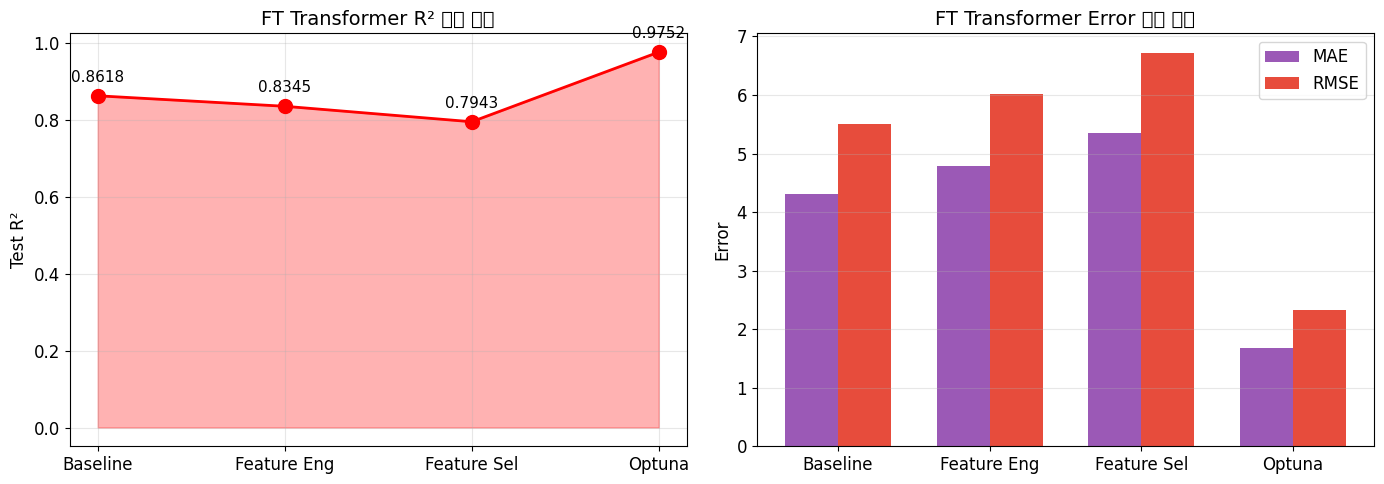

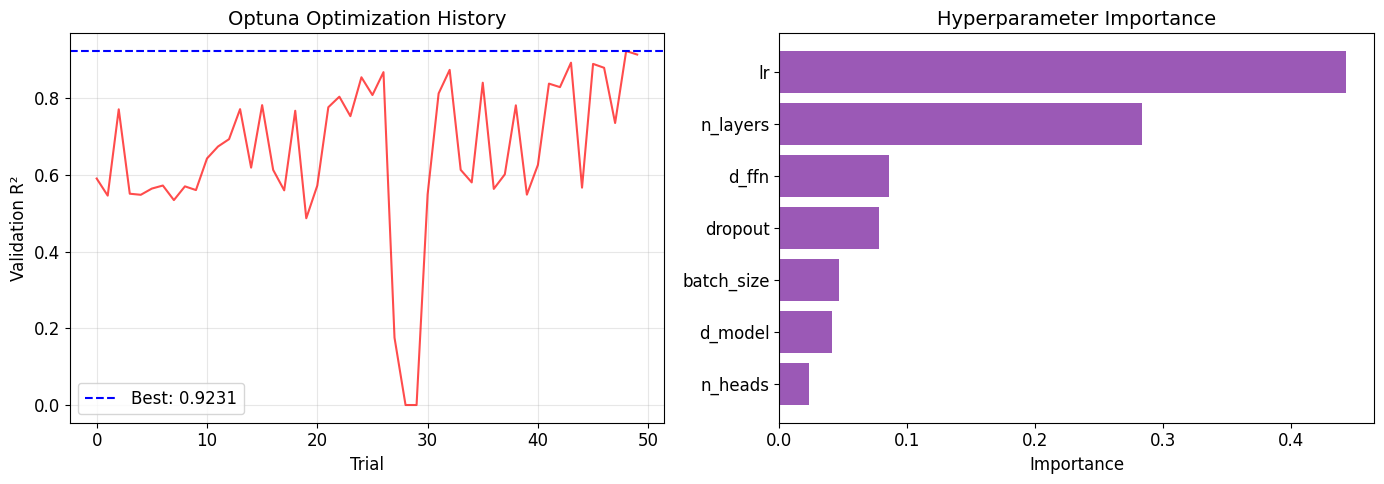


✅ FT Transformer 개선 완료!


In [ ]:
# ============================================
# 📦 라이브러리 설치
# ============================================
!pip install optuna -q

# ============================================
# 📚 라이브러리 임포트
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import optuna
from optuna.samplers import TPESampler

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================
# 🔧 FT Transformer 모델 정의
# ============================================
class NumericalEmbedding(nn.Module):
    def __init__(self, n_features, d_model):
        super().__init__()
        self.linear = nn.Linear(n_features, d_model)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        return self.norm(self.linear(x))


class FTTransformer(nn.Module):
    def __init__(self, n_num_features, d_model=64, n_heads=4, n_layers=2,
                 d_ffn=128, dropout=0.1, d_out=1):
        super().__init__()

        self.num_embedding = NumericalEmbedding(n_num_features, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ffn,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.head = nn.Sequential(
            nn.Linear(d_model, d_ffn),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ffn, d_out)
        )

    def forward(self, x_num):
        batch_size = x_num.size(0)
        num_emb = self.num_embedding(x_num).unsqueeze(1)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, num_emb], dim=1)
        x = self.transformer(x)
        return self.head(x[:, 0, :])


# ============================================
# 🔧 FT Transformer 학습 함수
# ============================================
def train_ft_transformer(X_train, y_train, X_val, y_val,
                         d_model=64, n_heads=4, n_layers=2, d_ffn=128,
                         dropout=0.1, lr=1e-3, batch_size=256,
                         n_epochs=100, patience=15, verbose=True):
    """FT Transformer 학습 함수"""

    # Tensor 변환
    X_train_t = torch.tensor(X_train.values if hasattr(X_train, 'values') else X_train,
                             dtype=torch.float32, device=device)
    X_val_t = torch.tensor(X_val.values if hasattr(X_val, 'values') else X_val,
                           dtype=torch.float32, device=device)
    y_train_t = torch.tensor(y_train.values if hasattr(y_train, 'values') else y_train,
                             dtype=torch.float32, device=device).reshape(-1, 1)
    y_val_t = torch.tensor(y_val.values if hasattr(y_val, 'values') else y_val,
                           dtype=torch.float32, device=device).reshape(-1, 1)

    # DataLoader
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # 모델 생성
    n_features = X_train_t.shape[1]
    model = FTTransformer(
        n_num_features=n_features,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ffn=d_ffn,
        dropout=dropout
    ).to(device)

    # 학습 설정
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    criterion = nn.MSELoss()

    # 학습
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(n_epochs):
        # Train
        model.train()
        for x_batch, y_batch in train_loader:
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                pred = model(x_batch)
                val_loss += criterion(pred, y_batch).item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1

        if verbose and (epoch + 1) % 20 == 0:
            print(f"  Epoch {epoch+1}/{n_epochs} | Val Loss: {val_loss:.4f}")

        if patience_counter >= patience:
            if verbose:
                print(f"  Early stopping at epoch {epoch+1}")
            break

    # Best model 복원
    model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

    return model


def evaluate_ft_transformer(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name="FT Transformer"):
    """FT Transformer 평가 함수"""

    # Tensor 변환
    X_val_t = torch.tensor(X_val.values if hasattr(X_val, 'values') else X_val,
                           dtype=torch.float32, device=device)
    X_test_t = torch.tensor(X_test.values if hasattr(X_test, 'values') else X_test,
                            dtype=torch.float32, device=device)

    # 예측
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_t).cpu().numpy().flatten()
        y_test_pred = model(X_test_t).cpu().numpy().flatten()

    # 평가
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f"{model_name}")
    print(f"  Validation R²: {val_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f} | MAE: {test_mae:.4f} | RMSE: {test_rmse:.4f}")

    return {'val_r2': val_r2, 'test_r2': test_r2, 'test_mae': test_mae, 'test_rmse': test_rmse}


# ============================================
# 📊 0단계: 베이스라인
# ============================================
print("=" * 70)
print("📊 0단계: 베이스라인 FT Transformer")
print("=" * 70)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_val_scaled = scaler.transform(X_val_reg)
X_test_scaled = scaler.transform(X_test_reg)

feature_names = X_train_reg.columns.tolist()
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_val_df = pd.DataFrame(X_val_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# 베이스라인 모델 학습
print("학습 시작...")
baseline_model = train_ft_transformer(
    X_train_df, y_train_reg, X_val_df, y_val_reg,
    d_model=64, n_heads=4, n_layers=2, d_ffn=128,
    dropout=0.1, lr=1e-3, verbose=True
)

baseline_results = evaluate_ft_transformer(
    baseline_model,
    X_train_df, y_train_reg,
    X_val_df, y_val_reg,
    X_test_df, y_test_reg,
    "\nBaseline FT Transformer"
)

# ============================================
# 🔨 1단계: 피처 엔지니어링
# ============================================
print("\n" + "=" * 70)
print("🔨 1단계: 피처 엔지니어링")
print("=" * 70)

def create_features(df, feature_names):
    """새로운 피처 생성"""
    df_new = df.copy()
    cols = feature_names

    # 1. 비율 피처
    if 'outstanding_debt' in cols and 'monthly_inhand_salary' in cols:
        idx_debt = cols.index('outstanding_debt')
        idx_salary = cols.index('monthly_inhand_salary')
        df_new['debt_to_income'] = df.iloc[:, idx_debt] / (df.iloc[:, idx_salary] + 1e-8)

    if 'total_emi_per_month' in cols and 'monthly_inhand_salary' in cols:
        idx_emi = cols.index('total_emi_per_month')
        idx_salary = cols.index('monthly_inhand_salary')
        df_new['emi_to_income'] = df.iloc[:, idx_emi] / (df.iloc[:, idx_salary] + 1e-8)

    if 'amount_invested_monthly' in cols and 'monthly_inhand_salary' in cols:
        idx_invest = cols.index('amount_invested_monthly')
        idx_salary = cols.index('monthly_inhand_salary')
        df_new['invest_to_income'] = df.iloc[:, idx_invest] / (df.iloc[:, idx_salary] + 1e-8)

    if 'num_of_loan' in cols and 'num_credit_card' in cols:
        idx_loan = cols.index('num_of_loan')
        idx_card = cols.index('num_credit_card')
        df_new['loan_per_card'] = df.iloc[:, idx_loan] / (df.iloc[:, idx_card] + 1e-8)

    # 2. 상호작용 피처
    if 'num_of_delayed_payment' in cols and 'interest_rate' in cols:
        idx_delay = cols.index('num_of_delayed_payment')
        idx_rate = cols.index('interest_rate')
        df_new['delay_interest_interaction'] = df.iloc[:, idx_delay] * df.iloc[:, idx_rate]

    if 'credit_utilization_ratio' in cols and 'outstanding_debt' in cols:
        idx_util = cols.index('credit_utilization_ratio')
        idx_debt = cols.index('outstanding_debt')
        df_new['util_debt_interaction'] = df.iloc[:, idx_util] * df.iloc[:, idx_debt]

    if 'age' in cols and 'credit_history_age' in cols:
        idx_age = cols.index('age')
        idx_history = cols.index('credit_history_age')
        df_new['age_history_interaction'] = df.iloc[:, idx_age] * df.iloc[:, idx_history]

    # 3. 집계 피처
    if 'num_bank_accounts' in cols and 'num_credit_card' in cols:
        idx_bank = cols.index('num_bank_accounts')
        idx_card = cols.index('num_credit_card')
        df_new['total_accounts'] = df.iloc[:, idx_bank] + df.iloc[:, idx_card]

    if 'outstanding_debt' in cols and 'total_emi_per_month' in cols and 'num_of_loan' in cols:
        idx_debt = cols.index('outstanding_debt')
        idx_emi = cols.index('total_emi_per_month')
        idx_loan = cols.index('num_of_loan')
        df_new['financial_burden'] = df.iloc[:, idx_debt] + df.iloc[:, idx_emi] * 12 + df.iloc[:, idx_loan] * 100

    # 4. 다항 피처
    if 'num_of_delayed_payment' in cols:
        idx_delay = cols.index('num_of_delayed_payment')
        df_new['delayed_payment_sq'] = df.iloc[:, idx_delay] ** 2

    if 'credit_utilization_ratio' in cols:
        idx_util = cols.index('credit_utilization_ratio')
        df_new['credit_util_sq'] = df.iloc[:, idx_util] ** 2

    # 5. 로그 변환
    if 'annual_income' in cols:
        idx_income = cols.index('annual_income')
        df_new['log_annual_income'] = np.log1p(np.abs(df.iloc[:, idx_income]))

    if 'outstanding_debt' in cols:
        idx_debt = cols.index('outstanding_debt')
        df_new['log_outstanding_debt'] = np.log1p(np.abs(df.iloc[:, idx_debt]))

    return df_new

# 피처 생성
X_train_fe = create_features(X_train_df, feature_names)
X_val_fe = create_features(X_val_df, feature_names)
X_test_fe = create_features(X_test_df, feature_names)

print(f"원본 피처 수: {len(feature_names)}")
print(f"피처 엔지니어링 후: {X_train_fe.shape[1]}")
print(f"새로 생성된 피처: {X_train_fe.shape[1] - len(feature_names)}개")

# 피처 엔지니어링 후 학습
print("\n학습 시작...")
fe_model = train_ft_transformer(
    X_train_fe, y_train_reg, X_val_fe, y_val_reg,
    d_model=64, n_heads=4, n_layers=2, d_ffn=128,
    dropout=0.1, lr=1e-3, verbose=True
)

fe_results = evaluate_ft_transformer(
    fe_model,
    X_train_fe, y_train_reg,
    X_val_fe, y_val_reg,
    X_test_fe, y_test_reg,
    "\n피처 엔지니어링 후 FT Transformer"
)

# ============================================
# 🎯 2단계: 피처 셀렉션
# ============================================
print("\n" + "=" * 70)
print("🎯 2단계: 피처 셀렉션")
print("=" * 70)

# XGBoost로 Feature Importance 계산 (더 빠르고 안정적)
print("\n[2-1] XGBoost Feature Importance 기반 선택")

temp_xgb = XGBRegressor(n_estimators=100, max_depth=6, random_state=42, verbosity=0)
temp_xgb.fit(X_train_fe, y_train_reg)

importance_df = pd.DataFrame({
    'feature': X_train_fe.columns,
    'importance': temp_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 중요 피처:")
print(importance_df.head(15).to_string(index=False))

# 상관관계 기반 중복 제거
print("\n[2-2] 높은 상관관계 피처 제거")

corr_matrix = X_train_fe.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

features_to_drop = set()
for col in upper_tri.columns:
    correlated = upper_tri.index[upper_tri[col] > 0.95].tolist()
    for corr_col in correlated:
        imp1 = importance_df[importance_df['feature'] == col]['importance'].values
        imp2 = importance_df[importance_df['feature'] == corr_col]['importance'].values
        imp1 = imp1[0] if len(imp1) > 0 else 0
        imp2 = imp2[0] if len(imp2) > 0 else 0

        if imp1 < imp2:
            features_to_drop.add(col)
        else:
            features_to_drop.add(corr_col)

print(f"제거할 피처 수: {len(features_to_drop)}")

# 최종 피처 선택
remaining_features = [f for f in importance_df['feature'] if f not in features_to_drop]
top_k = min(40, len(remaining_features))
selected_features = remaining_features[:top_k]

print(f"최종 선택된 피처 수: {len(selected_features)}")

X_train_selected = X_train_fe[selected_features]
X_val_selected = X_val_fe[selected_features]
X_test_selected = X_test_fe[selected_features]

# 피처 선택 후 학습
print("\n학습 시작...")
fs_model = train_ft_transformer(
    X_train_selected, y_train_reg, X_val_selected, y_val_reg,
    d_model=64, n_heads=4, n_layers=2, d_ffn=128,
    dropout=0.1, lr=1e-3, verbose=True
)

fs_results = evaluate_ft_transformer(
    fs_model,
    X_train_selected, y_train_reg,
    X_val_selected, y_val_reg,
    X_test_selected, y_test_reg,
    "\n피처 셀렉션 후 FT Transformer"
)

# ============================================
# ⚡ 3단계: Optuna 하이퍼파라미터 튜닝
# ============================================
print("\n" + "=" * 70)
print("⚡ 3단계: Optuna 하이퍼파라미터 튜닝")
print("=" * 70)

def objective(trial):
    """Optuna 목적 함수 (FT Transformer)"""

    # 하이퍼파라미터 탐색 범위
    d_model = trial.suggest_categorical('d_model', [32, 64, 128])
    n_heads = trial.suggest_categorical('n_heads', [2, 4, 8])
    n_layers = trial.suggest_int('n_layers', 1, 4)
    d_ffn = trial.suggest_categorical('d_ffn', [64, 128, 256])
    dropout = trial.suggest_float('dropout', 0.0, 0.3)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])

    # d_model이 n_heads로 나누어떨어져야 함
    if d_model % n_heads != 0:
        return 0.0

    try:
        # 모델 학습
        model = train_ft_transformer(
            X_train_selected, y_train_reg, X_val_selected, y_val_reg,
            d_model=d_model, n_heads=n_heads, n_layers=n_layers, d_ffn=d_ffn,
            dropout=dropout, lr=lr, batch_size=batch_size,
            n_epochs=50, patience=10, verbose=False
        )

        # 검증 성능 계산
        X_val_t = torch.tensor(X_val_selected.values, dtype=torch.float32, device=device)
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_t).cpu().numpy().flatten()

        val_r2 = r2_score(y_val_reg, y_val_pred)
        return val_r2

    except Exception as e:
        return 0.0

# Optuna 최적화
print("Optuna 최적화 시작... (50 trials)")
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50, show_progress_bar=True)

# 최적 파라미터 출력
print(f"\n최적 Validation R²: {study.best_value:.4f}")
print("\n최적 하이퍼파라미터:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# 최적 파라미터로 최종 모델 학습
print("\n최적 파라미터로 최종 모델 학습...")
best_params = study.best_params

best_model = train_ft_transformer(
    X_train_selected, y_train_reg, X_val_selected, y_val_reg,
    d_model=best_params['d_model'],
    n_heads=best_params['n_heads'],
    n_layers=best_params['n_layers'],
    d_ffn=best_params['d_ffn'],
    dropout=best_params['dropout'],
    lr=best_params['lr'],
    batch_size=best_params['batch_size'],
    n_epochs=100, patience=15, verbose=True
)

tuned_results = evaluate_ft_transformer(
    best_model,
    X_train_selected, y_train_reg,
    X_val_selected, y_val_reg,
    X_test_selected, y_test_reg,
    "\nOptuna 튜닝 후 FT Transformer"
)

# ============================================
# 📊 최종 결과 비교
# ============================================
print("\n" + "=" * 70)
print("📊 FT Transformer 개선 과정 요약")
print("=" * 70)

comparison = pd.DataFrame({
    '단계': ['0. Baseline', '1. Feature Engineering', '2. Feature Selection', '3. Optuna Tuning'],
    'Val R²': [baseline_results['val_r2'], fe_results['val_r2'], fs_results['val_r2'], tuned_results['val_r2']],
    'Test R²': [baseline_results['test_r2'], fe_results['test_r2'], fs_results['test_r2'], tuned_results['test_r2']],
    'Test MAE': [baseline_results['test_mae'], fe_results['test_mae'], fs_results['test_mae'], tuned_results['test_mae']],
    'Test RMSE': [baseline_results['test_rmse'], fe_results['test_rmse'], fs_results['test_rmse'], tuned_results['test_rmse']]
})

print(comparison.to_string(index=False))

# 개선율 계산
improvement = (tuned_results['test_r2'] - baseline_results['test_r2']) / baseline_results['test_r2'] * 100
print(f"\n🚀 총 R² 개선율: {improvement:.2f}%")
print(f"   Baseline: {baseline_results['test_r2']:.4f} → Final: {tuned_results['test_r2']:.4f}")

# ============================================
# 📈 시각화
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² 변화
stages = ['Baseline', 'Feature Eng', 'Feature Sel', 'Optuna']
r2_scores = [baseline_results['test_r2'], fe_results['test_r2'],
             fs_results['test_r2'], tuned_results['test_r2']]

axes[0].plot(stages, r2_scores, 'ro-', markersize=10, linewidth=2)
axes[0].fill_between(stages, r2_scores, alpha=0.3, color='red')
axes[0].set_ylabel('Test R²', fontsize=12)
axes[0].set_title('FT Transformer R² 개선 과정', fontsize=14)
axes[0].grid(True, alpha=0.3)
for i, (stage, score) in enumerate(zip(stages, r2_scores)):
    axes[0].annotate(f'{score:.4f}', (i, score), textcoords="offset points",
                     xytext=(0, 10), ha='center', fontsize=11)

# MAE, RMSE 변화
mae_scores = [baseline_results['test_mae'], fe_results['test_mae'],
              fs_results['test_mae'], tuned_results['test_mae']]
rmse_scores = [baseline_results['test_rmse'], fe_results['test_rmse'],
               fs_results['test_rmse'], tuned_results['test_rmse']]

x = np.arange(len(stages))
width = 0.35
axes[1].bar(x - width/2, mae_scores, width, label='MAE', color='#9b59b6')
axes[1].bar(x + width/2, rmse_scores, width, label='RMSE', color='#e74c3c')
axes[1].set_xticks(x)
axes[1].set_xticklabels(stages)
axes[1].set_ylabel('Error', fontsize=12)
axes[1].set_title('FT Transformer Error 감소 과정', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('ft_transformer_improvement.png', dpi=150, bbox_inches='tight')
plt.show()

# Optuna 분석 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 최적화 히스토리
trials_df = study.trials_dataframe()
axes[0].plot(trials_df['value'], 'r-', alpha=0.7)
axes[0].axhline(y=study.best_value, color='b', linestyle='--', label=f'Best: {study.best_value:.4f}')
axes[0].set_xlabel('Trial', fontsize=12)
axes[0].set_ylabel('Validation R²', fontsize=12)
axes[0].set_title('Optuna Optimization History', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 파라미터 중요도
try:
    param_importance = optuna.importance.get_param_importances(study)
    params = list(param_importance.keys())
    importance_values = [param_importance[p] for p in params]

    axes[1].barh(params, importance_values, color='#9b59b6')
    axes[1].set_xlabel('Importance', fontsize=12)
    axes[1].set_title('Hyperparameter Importance', fontsize=14)
    axes[1].invert_yaxis()
except:
    axes[1].text(0.5, 0.5, 'Importance 계산 불가', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.savefig('ft_optuna_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ FT Transformer 개선 완료!")